In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import descartes
import sys
import sklearn
from datetime import datetime as dt
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/packages/gpd_lite_toolbox')
sys.path.append('/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/code/functions/')
from gis_processing import *
import gpd_lite_toolbox as glt
# and also some slightly modified functions from geopandas.plotting :
from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon

In [3]:
data_dir = '/Users/saraprice/Documents/NYU/Fall_2020/DS_GA_1001/final_project/wildfires-1001/data'

### Load Data

In [4]:
CA_counties = gpd.read_file(os.path.join(data_dir, 'raw_data/counties_gis/CA_Counties_TIGER2016.shp'))
fire_data = gpd.read_file(os.path.join(data_dir, 'clean_data/fire_gis/fire_gis.dbf'))
CA_boundary = gpd.read_file(os.path.join(data_dir, 'clean_data/CA_boundary/CA_boundary.shp'))

In [5]:
## Check crs
print(CA_counties.crs)
print(fire_data.crs)
print(CA_boundary.crs)

epsg:3857
epsg:3857
epsg:3857


In [6]:
CA_counties_clean = CA_counties[['NAME', 'COUNTYFP', 'GEOID', 'ALAND', 'AWATER', 'geometry']]
CA_counties_clean['COUNTY_AREA'] = CA_counties_clean.geometry.area
CA_counties_clean.head()

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,NAME,COUNTYFP,GEOID,ALAND,AWATER,geometry,COUNTY_AREA
0,Sierra,091,06091,2468694587,23299110,"POLYGON ((-13431319.751 4821511.426, -13431312...",4.200450e+09
1,Sacramento,067,06067,2499183617,76073827,"POLYGON ((-13490651.476 4680831.603, -13490511...",4.205267e+09
2,Santa Barbara,083,06083,7084000598,2729814515,"MULTIPOLYGON (((-13423116.772 4042044.149, -13...",1.449841e+10
3,Calaveras,009,06009,2641820834,43806026,"POLYGON ((-13428575.483 4627725.228, -13428534...",4.356213e+09
4,Ventura,111,06111,4773390489,945942791,"MULTIPOLYGON (((-13317853.594 3931602.414, -13...",8.413293e+09


### Generate Grid
User inputs to test out:
* width and height in generate_grid (in next cell - view updates in the following cell for plotting)

In [19]:
##Generate grid of equal-sizes areas across CA
grid = generate_grid(CA_counties['geometry'], width = 71000, height = 71000, crs = '3857')
print(grid.head())

                                            geometry
0  POLYGON ((-13857275.000 5110930.000, -13786275...
1  POLYGON ((-13857275.000 5039930.000, -13786275...
2  POLYGON ((-13857275.000 4968930.000, -13786275...
3  POLYGON ((-13857275.000 4897930.000, -13786275...
4  POLYGON ((-13857275.000 4826930.000, -13786275...


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


165

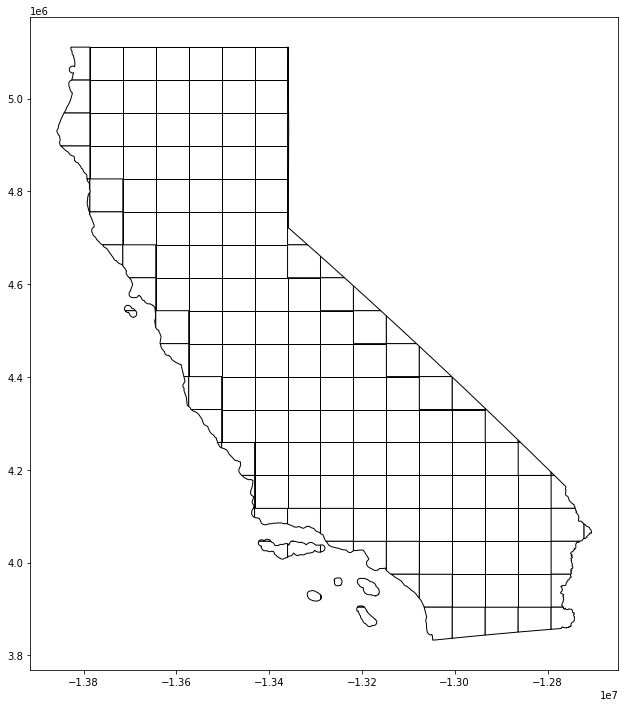

In [46]:
#Overlay CA boundary with grid
ca_grid = gpd.overlay(CA_boundary,grid, how='intersection')
ca_grid.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
len(ca_grid)

In [47]:
#Get areas of each grid section and calculate proportion of total area (this will be used for trimming)
ca_grid['GRID_AREA'] =ca_grid.geometry.area
ca_grid['GRID_AREA'].describe()

count    1.650000e+02
mean     3.925941e+09
std      1.769080e+09
min      4.391166e-04
25%      2.856194e+09
50%      5.041000e+09
75%      5.041000e+09
max      5.041000e+09
Name: GRID_AREA, dtype: float64

### Trim Grid
User input to test out:
* quantile for minimum area we want each grid section to have (set in the following cell). This is our metric for trimming down the grid to only include sections w/ significant area

In [48]:
print("Original number of grid sections: {}".format(ca_grid.shape[0]))
min_area = np.quantile(ca_grid['GRID_AREA'], 0.1)
ca_grid_trimmed = ca_grid[ca_grid['GRID_AREA']>min_area]
print("Trimmed number of grid sections: {}".format(ca_grid_trimmed.shape[0]))

Original number of grid sections: 165
Trimmed number of grid sections: 148


(148, 3)

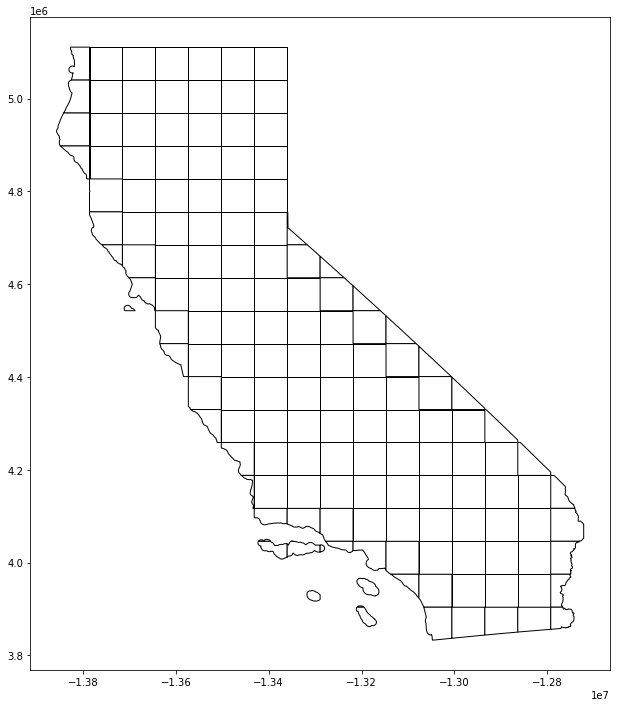

In [49]:
ca_grid_trimmed.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
ca_grid_trimmed.shape

### Overlay Trimmed Grim onto county data
This will slice up the grid sections based on county overlap and create new geometries that are those subsections. We will want to calculate the size of these subsections and for each grid section select the sub-section that is largest. The county associated with that section will be the one attached to the grid section

In [50]:
#Assign key to each grid section
ca_grid_trimmed['GRID_ID'] = range(len(ca_grid_trimmed))

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [51]:
county_grid = gpd.overlay(CA_counties_clean,ca_grid_trimmed,  how = 'intersection')
county_grid['COUNTY_GRID_OVLP_AREA'] = county_grid.geometry.area
county_grid['COUNTY_GRID_OVLP_PROP'] = county_grid['COUNTY_GRID_OVLP_AREA']/county_grid['GRID_AREA']

#### Illustrating how ugly the projection of the county lines onto the grid is

<AxesSubplot:>

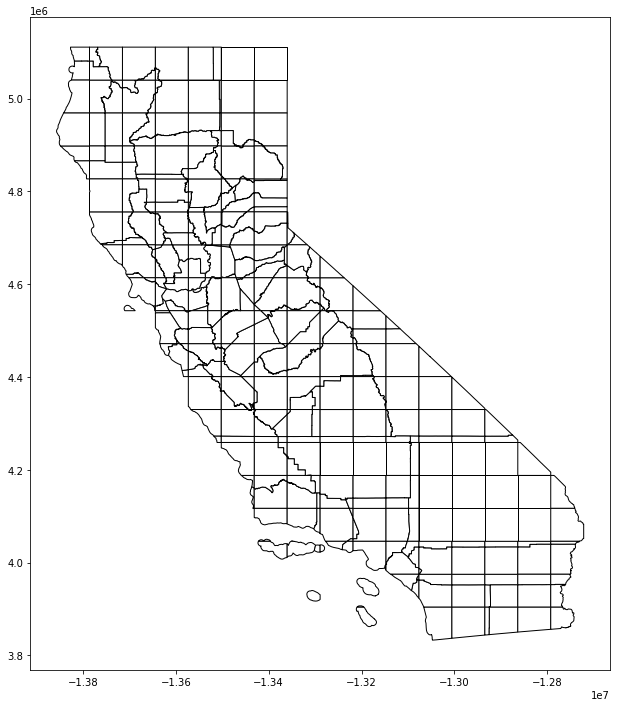

In [52]:
county_grid.plot(color = 'white', edgecolor = 'black', figsize= (12,12))

In [90]:
ca_grid_trimmed.head()
county_grid

,FID,geometry,GRID_AREA,GRID_ID
0,0,"POLYGON ((-13818818.380 5081091.901, -13818966...",2.665977e+09,0
1,0,"POLYGON ((-13842061.903 4968930.000, -13841787...",3.160141e+09,1
2,0,"POLYGON ((-13848706.710 4897930.000, -13849372...",4.610932e+09,2
3,0,"POLYGON ((-13792394.058 4826930.000, -13792399...",2.060371e+09,3
6,0,"POLYGON ((-13786275.000 5110930.000, -13715275...",5.041000e+09,4


In [116]:
#Group by grid id to get proportions of counties in each grid section
print("# sections in trimmed grid: {}".format(len(ca_grid_trimmed)))
county_grid_grp = county_grid[['GRID_ID', 'COUNTY_GRID_OVLP_PROP']].groupby('GRID_ID').max().reset_index()
#Merge the max county back onto the full county_grid data
county_grid_trimmed = ca_grid_trimmed.merge(county_grid_grp, on = ['GRID_ID'])
print(len(county_grid_trimmed))
county_grid_trimmed.head()

# sections in trimmed grid: 148
148


,FID,geometry,GRID_AREA,GRID_ID,COUNTY_GRID_OVLP_PROP
0,0,"POLYGON ((-13818818.380 5081091.901, -13818966...",2.665977e+09,0,0.585754
1,0,"POLYGON ((-13842061.903 4968930.000, -13841787...",3.160141e+09,1,1.000000
2,0,"POLYGON ((-13848706.710 4897930.000, -13849372...",4.610932e+09,2,1.000000
3,0,"POLYGON ((-13792394.058 4826930.000, -13792399...",2.060371e+09,3,0.695598
4,0,"POLYGON ((-13786275.000 5110930.000, -13715275...",5.041000e+09,4,0.582516


In [106]:
county_grid2['COUNTY_GRID_OVLP_PROP'].describe()

count    148.000000
mean       0.767110
std        0.213395
min        0.305652
25%        0.561854
50%        0.809541
75%        0.999939
max        1.000000
Name: COUNTY_GRID_OVLP_PROP, dtype: float64

In [123]:
#Want to map this dataframe w/ grid section geometry, grid_area, and grid_id back onto full county data but we want to keep the grid section geometry and not the county geometry
print("# of geometries after overly counties onto the grid: {}".format(len(county_grid)))

#Save non-geometry county data into new dataframe
drop_cols = ['geometry', 'FID']
county_df = county_grid[[i for i in county_grid.columns if i not in drop_cols]]

#Merge back together
print(county_df.columns.tolist())
print(county_grid_trimmed.columns.tolist())
county_grid_final = county_df.merge(county_grid_trimmed, on = ['GRID_AREA', 'GRID_ID', 'COUNTY_GRID_OVLP_PROP'])
county_grid_final = gpd.GeoDataFrame(county_grid_final, geometry = county_grid_final.geometry, \
                                     crs={'init' :'epsg:3857'})
print(len(county_grid_final))
print(type(county_grid_final))
county_grid_final.head()

# of geometries after overly counties onto the grid: 385
['NAME', 'COUNTYFP', 'GEOID', 'ALAND', 'AWATER', 'COUNTY_AREA', 'GRID_AREA', 'GRID_ID', 'COUNTY_GRID_OVLP_AREA', 'COUNTY_GRID_OVLP_PROP']
['FID', 'geometry', 'GRID_AREA', 'GRID_ID', 'COUNTY_GRID_OVLP_PROP']
148
<class 'geopandas.geodataframe.GeoDataFrame'>


/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,NAME,COUNTYFP,GEOID,ALAND,AWATER,COUNTY_AREA,GRID_AREA,GRID_ID,COUNTY_GRID_OVLP_AREA,COUNTY_GRID_OVLP_PROP,FID,geometry
0,Plumas,063,06063,6612400993,156387635,1.155000e+10,5.041000e+09,44,4.936293e+09,0.979229,0,"POLYGON ((-13502275.000 4897930.000, -13431275..."
1,Nevada,057,06057,2480606160,41513172,4.217591e+09,5.041000e+09,45,1.540790e+09,0.305652,0,"POLYGON ((-13502275.000 4826930.000, -13431275..."
2,Sierra,091,06091,2468694587,23299110,4.200450e+09,5.041000e+09,59,2.544187e+09,0.504699,0,"POLYGON ((-13431275.000 4826930.000, -13360275..."
3,Sacramento,067,06067,2499183617,76073827,4.205267e+09,5.041000e+09,35,2.029400e+09,0.402579,0,"POLYGON ((-13573275.000 4684930.000, -13502275..."
4,San Joaquin,077,06077,3606276598,89025932,5.950289e+09,5.041000e+09,36,2.063091e+09,0.409262,0,"POLYGON ((-13573275.000 4613930.000, -13502275..."


Check proportions of max county in the grid area - we want this to be reasonably hight but also recognize that given the irregularities of county shape, we can't expect to get a majority for every grid section


#### Illustrating a section of the grid above that had multiple counties
(Feel free to play around with plotting some other ones)

In [56]:
#find grid section w/ multiple counties
county_grid['GRID_ID'].value_counts()

26     7
45     6
47     6
27     6
85     6
      ..
118    1
121    1
122    1
124    1
147    1
Name: GRID_ID, Length: 148, dtype: int64

In [60]:
sub_plot = county_grid[county_grid['GRID_ID']==27]
sub_plot['center'] = sub_plot['geometry'].centroid
sub_plot_points = sub_plot.copy()
sub_plot_points.set_geometry('center', inplace = True)

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


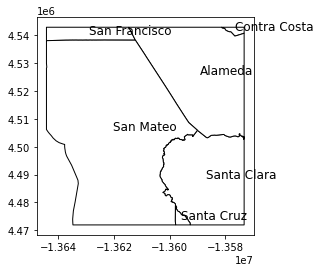

In [61]:
sub_plot.plot(color = 'white', edgecolor = 'black')

texts = []
for x, y, label in zip(sub_plot_points.geometry.x, sub_plot_points.geometry.y, sub_plot_points["NAME"]):
    texts.append(plt.text(x, y, label, fontsize = 12))

### You can ignore what's in the below cell
Below is some code I used to loop through different grid sizes - was thinking about trying to balance grid size with unique new geometries when overlaying counties and grid. Didn't really work super well but didn't want to delete.

In [479]:
len_grid_county = 1000
best_size = 0
for i in np.arange(80000, 83000, 1000):
    grid = generate_grid(CA_counties['geometry'], i, i)
    grid = grid.set_crs("EPSG:3857")
    ca_grid = gpd.overlay(ca_boundary,grid, how='intersection')
    ca_grid['area'] =ca_grid.geometry.area
    ca_grid['area_prop'] = ca_grid['area']/ca_grid['area'].sum(axis = 0)
    min_area = np.quantile(ca_grid['area'], 0.15)
    ca_grid_trimmed = ca_grid[ca_grid['area']>min_area]
    ca_grid_trimmed['grid_id'] = pd.Series(range(len(ca_grid_trimmed)))
    county_grid = gpd.overlay(CA_counties_clean,ca_grid_trimmed,  how = 'intersection')
    if len(county_grid)<=len_grid_county:
        len_grid_county = len(county_grid)
        best_size = i
        print(len_grid_county, len(ca_grid_trimmed), i)
    else:
        continue

                                            geometry          area  area_prop  \
0  POLYGON ((-13821906.518 4875930.000, -13822422...  1.983437e+10   0.032642   
0  POLYGON ((-13821906.518 4875930.000, -13822422...  1.983437e+10   0.032642   
0  POLYGON ((-13821906.518 4875930.000, -13822422...  1.983437e+10   0.032642   
1  POLYGON ((-13777116.317 4726930.000, -13777131...  1.268745e+10   0.020880   
1  POLYGON ((-13777116.317 4726930.000, -13777131...  1.268745e+10   0.020880   

   grid_id  index_right       NAME COUNTYFP        ALAND      AWATER  
0        0           30   Humboldt      023   9240992572  1254297982  
0        0           17    Trinity      105   8234265201    73407949  
0        0           54   Siskiyou      093  16261974847   179108278  
1        1           30   Humboldt      023   9240992572  1254297982  
1        1           18  Mendocino      045   9081421729   962951511  


3     7
2     7
7     5
4     5
5     3
1     3
8     2
15    1
12    1
11    1
6     1
Name: index_right, dtype: int64

<AxesSubplot:>

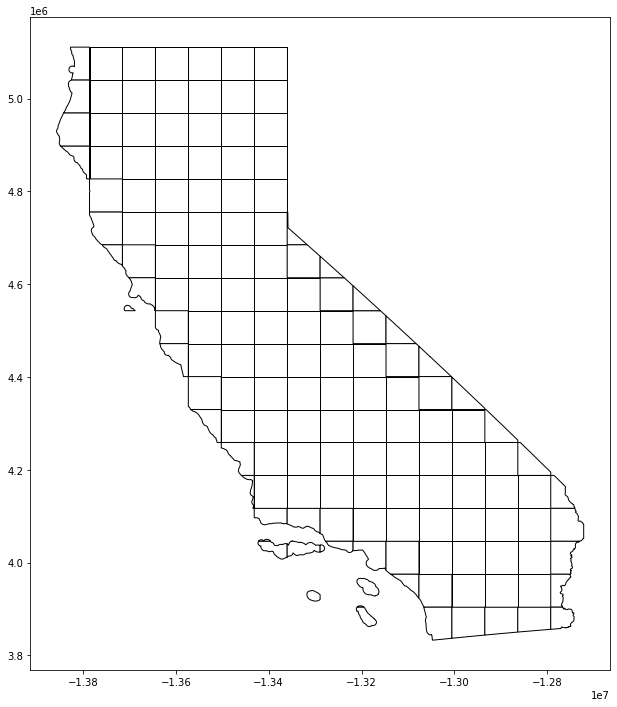

In [132]:
county_grid_final.plot(color = 'white', edgecolor = 'black', figsize = (12, 12))

### Projecting Wildfires onto the grid

In [138]:
##Converting ALARM_DATE and CONT_DATE to datetime instead of strs as they are stored in shape file
fire_data['ALARM_DATE'] = pd.to_datetime(fire_data['ALARM_DATE'], format = '%Y-%m-%d', errors = 'coerce')
fire_data['CONT_DATE'] = pd.to_datetime(fire_data['CONT_DATE'], format = '%Y-%m-%d', errors = 'coerce')

<AxesSubplot:>

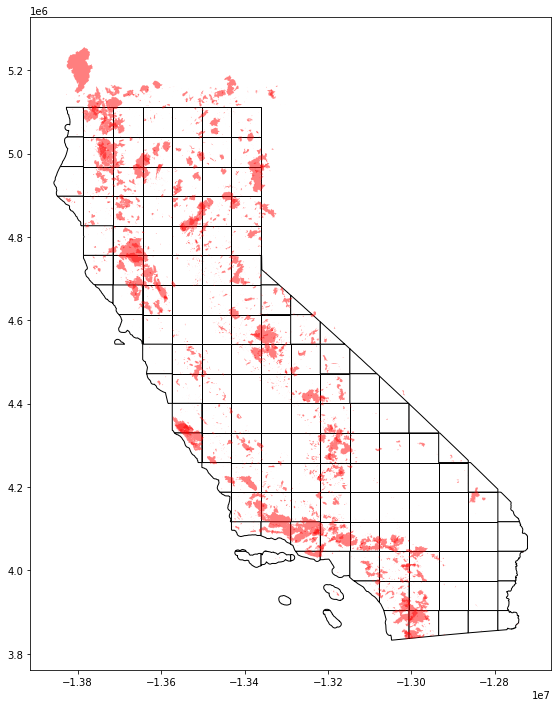

In [124]:
#Plot this fire data onto the grid
ax = county_grid_final.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
fire_data.plot(ax=ax, color = 'red', alpha = 0.5, figsize = (12,12))

Clearly some fires in the north are outside the state boundary - we can cut those out by using overlay with "union"

In [136]:
#Join fire data with county data so we're just looking at fires w/in the bounds of the state
fire_county_grid = gpd.sjoin(fire_data, county_grid_final, op = 'intersects')

<AxesSubplot:>

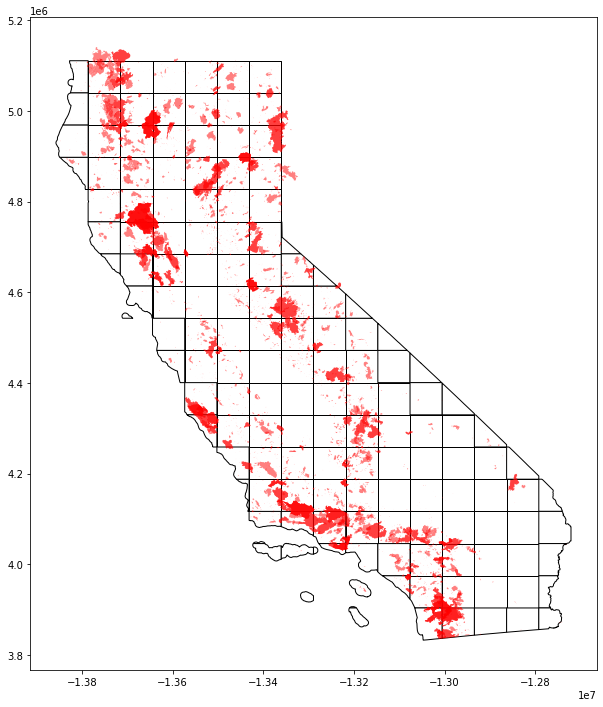

In [137]:
#Plot this fire data onto the grid
ax = county_grid_final.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
fire_county_grid.plot(ax=ax, color = 'red', alpha = 0.5, figsize = (12,12))

### Weather Data

In [140]:
noaa = pd.read_csv(os.path.join(data_dir, 'clean_data/NOAA-station-lists/station_list_v1.csv'))
noaa_gdf = gpd.GeoDataFrame(noaa, geometry = gpd.points_from_xy(noaa.LONGITUDE, noaa.LATITUDE), \
                            crs={'init' :'epsg:4326'})

/Applications/anaconda3/envs/geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [141]:
noaa_gdf = noaa_gdf.to_crs('epsg:3857')

In [142]:
noaa_gdf.head()

,Unnamed: 0,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry
0,88883,USC00040136,32.8358,-116.7775,516.6,CA,ALPINE,NaN,NaN,NaN,POINT (-12999611.836 3873529.386)
1,88889,USC00040192,33.8647,-117.8425,71.6,CA,ANAHEIM,NaN,NaN,NaN,POINT (-13118167.094 4010648.978)
2,88891,USC00040212,38.5731,-122.4406,522.7,CA,ANGWIN PACIFIC UNION COLLEGE,NaN,NaN,NaN,POINT (-13630025.244 4660704.985)
3,88894,USC00040232,37.9833,-121.7525,18.3,CA,ANTIOCH PUMPING PLT #3,NaN,NaN,NaN,POINT (-13553426.303 4577066.932)
4,88903,USC00040343,36.4914,-118.8253,520.6,CA,ASH MTN,NaN,NaN,NaN,POINT (-13227571.889 4368449.634)


<AxesSubplot:>

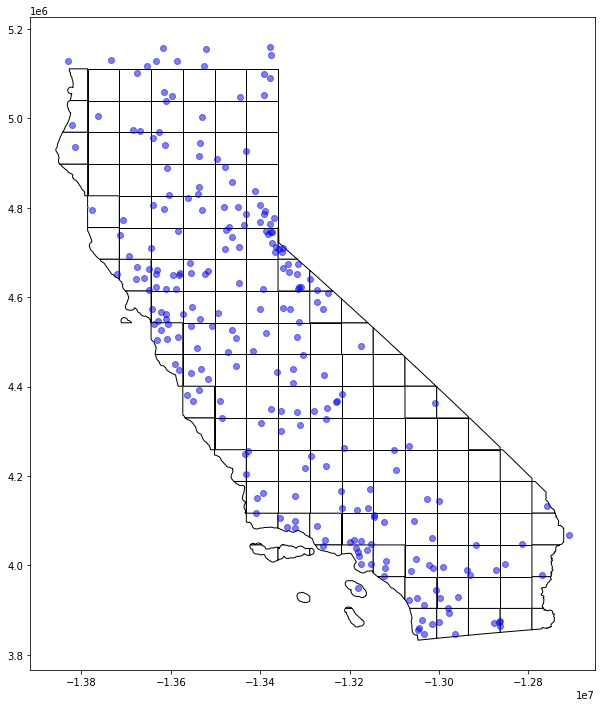

In [143]:
ax = county_grid_final.plot(color = 'white', edgecolor = 'black', figsize = (12,12))
noaa_gdf.plot(ax=ax, color = 'blue', alpha = 0.5, figsize = (12,12))

In [781]:
noaa_gdf.head()

,Unnamed: 0,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID,geometry
0,88883,USC00040136,32.8358,-116.7775,516.6,CA,ALPINE,NaN,NaN,NaN,POINT (-116.77750 32.83580)
1,88889,USC00040192,33.8647,-117.8425,71.6,CA,ANAHEIM,NaN,NaN,NaN,POINT (-117.84250 33.86470)
2,88891,USC00040212,38.5731,-122.4406,522.7,CA,ANGWIN PACIFIC UNION COLLEGE,NaN,NaN,NaN,POINT (-122.44060 38.57310)
3,88894,USC00040232,37.9833,-121.7525,18.3,CA,ANTIOCH PUMPING PLT #3,NaN,NaN,NaN,POINT (-121.75250 37.98330)
4,88903,USC00040343,36.4914,-118.8253,520.6,CA,ASH MTN,NaN,NaN,NaN,POINT (-118.82530 36.49140)
